#### Importing necessary Libraries

In [ ]:
import time
from collections import deque, namedtuple
import gym
import numpy as np
import PIL.Image
import tensorflow as tf
import Attari_Breakout.utils as utils

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

c:\Users\amann\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\__init__.py:30: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils as _distutils
c:\Users\amann\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\lite\python\util.py:51: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs.
  from jax import xla_computation as _xla_computation


#### Setting the seed

In [2]:
tf.random.set_seed(utils.SEED)

#### Hyperparameters

In [ ]:
MEMORY_SIZE = 100000
GAMMA = 0.99
ALPHA = 1e-3
NUM_STEPS_FOR_UPDATE = 1

#### MountainCar environment

In [4]:
env = gym.make('CartPole-v1')

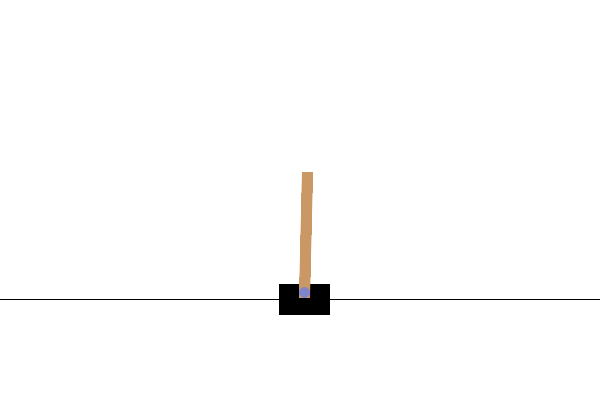

In [5]:
env.reset()
PIL.Image.fromarray(env.render(mode='rgb_array'))

In [6]:
state_size = env.observation_space.shape
num_actions = env.action_space.n

print("State Shape:",state_size) # Position of the car and velocity
print("Number of actions:",num_actions) # push left , no push , push right

State Shape: (4,)
Number of actions: 2


In [7]:
initial_state = env.reset()

In [8]:
action = 0
next_state, reward, done, info = env.step(action)

with np.printoptions(formatter={'float': '{:.3f}'.format}):
    print("Initial State:",initial_state)
    print("Action:",action)
    print("Next State:",next_state)
    print("Reward Received:", reward)
    print("Episode Terminated:",done)
    print("Info:",info)

Initial State: [0.036 0.004 -0.020 -0.008]
Action: 0
Next State: [0.036 -0.191 -0.020 0.279]
Reward Received: 1.0
Episode Terminated: False
Info: {}


### Deep Q-Learning

#### Target Netwok and Q Network

In [ ]:
q_network = Sequential([
    Input(shape=state_size),
    Dense(units=64,activation='relu'),
    Dense(units=64,activation='relu'),
    Dense(units=num_actions,activation='linear')
])

target_q_network = Sequential([
    Input(shape=state_size),
    Dense(units=64,activation='relu'),
    Dense(units=64,activation='relu'),
    Dense(units=num_actions,activation='linear')
])

optimizer = Adam(learning_rate=ALPHA)

#### Experience Replay

In [10]:
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

In [11]:
def compute_loss(experiences, gamma, q_network, target_q_network):
    states, actions, rewards, next_states , done_vals = experiences

    max_qsa = tf.reduce_max(target_q_network(next_states),axis=-1)

    y_targets = rewards + (gamma * max_qsa * (1 - done_vals))

    q_values = q_network(states)

    q_values = tf.gather_nd(q_values , tf.stack([tf.range(q_values.shape[0]), tf.cast(actions, tf.int32)], axis=1))

    loss = MSE(y_targets,q_values)

    return loss

In [12]:
@tf.function
def agent_learn(experiences, gamma):

    with tf.GradientTape() as tape:
        loss = compute_loss(experiences,gamma,q_network,target_q_network)

    gradients = tape.gradient(loss,q_network.trainable_variables)
    optimizer.apply_gradients(zip(gradients,q_network.trainable_variables))

    utils.update_target_network(q_network,target_q_network)

### Train the agent

In [13]:
start = time.time()

num_episodes = 2000
max_num_timestamps = 500  # max for CartPole-v1
num_p_av = 100
epsilon = 1.0
goal_reached = False

total_points_history = []
memory_buffer = deque(maxlen=MEMORY_SIZE)

target_q_network.set_weights(q_network.get_weights())  # sync Q networks

for i in range(num_episodes):

    state = env.reset()
    total_points = 0

    for t in range(max_num_timestamps):

        state_qn = np.expand_dims(state, axis=0)
        q_values = q_network(state_qn)
        action = utils.get_action(q_values, epsilon, num_actions)

        next_state, reward, done, _ = env.step(int(action))

        # In CartPole, the reward is always +1 until termination
        memory_buffer.append(experience(state, action, reward, next_state, done))

        if utils.check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer):
            experiences = utils.get_experiences(memory_buffer)
            agent_learn(experiences, GAMMA)

        state = next_state.copy()
        total_points += reward

        if done:
            break

    total_points_history.append(total_points)
    av_latest_points = np.mean(total_points_history[-num_p_av:])
    epsilon = utils.get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Average reward (last {num_p_av}): {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Average reward (last {num_p_av}): {av_latest_points:.2f}")

    # Success condition: average > 475 over last 100 episodes
    if av_latest_points >= 475.0:
        q_network.save('CartPole_model.h5')
        print(f"\n\n✅ CartPole solved in {i+1} episodes!")
        goal_reached = True
        break

tot_time = time.time() - start
print(f"\nTotal Runtime: {tot_time:.2f} s ({tot_time / 60:.2f} min)")

Episode 100 | Average reward (last 100): 23.86
Episode 200 | Average reward (last 100): 26.75
Episode 300 | Average reward (last 100): 35.11
Episode 400 | Average reward (last 100): 53.52
Episode 500 | Average reward (last 100): 59.59
Episode 600 | Average reward (last 100): 79.26
Episode 700 | Average reward (last 100): 57.42
Episode 800 | Average reward (last 100): 39.23
Episode 900 | Average reward (last 100): 56.53
Episode 1000 | Average reward (last 100): 60.05
Episode 1100 | Average reward (last 100): 83.05
Episode 1200 | Average reward (last 100): 97.896
Episode 1300 | Average reward (last 100): 117.74
Episode 1400 | Average reward (last 100): 120.75
Episode 1500 | Average reward (last 100): 140.38
Episode 1600 | Average reward (last 100): 162.57
Episode 1700 | Average reward (last 100): 160.49
Episode 1800 | Average reward (last 100): 283.27
Episode 1900 | Average reward (last 100): 293.05
Episode 2000 | Average reward (last 100): 166.22

Total Runtime: 1038.01 s (17.30 min)


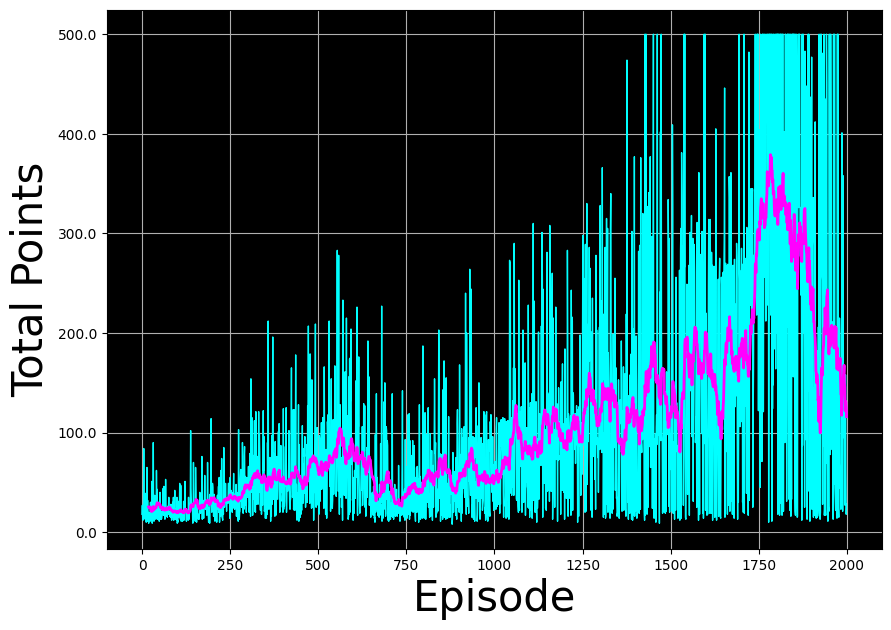

In [14]:
# Plot the point history
utils.plot_history(total_points_history)

In [15]:
# Suppress warnings from imageio
import logging
logging.getLogger().setLevel(logging.ERROR)

In [16]:
filename = "./videos/cart_pole.mp4"

utils.create_video(filename, env, q_network)
utils.embed_mp4(filename)